# **Assignment 1: Identify sets of dealers doing circular trading.  Using Node2Vec.** 

## Submitted by:

1. Nitish Kumar Gundapu **AI22MTECH14004** \\
2. Soumyanetra Pal **AI22MTECH14005** \\
3. Major Raviraj Deshmukh **AI22MTECH13008** \\
4. Vishnu Vijay Tiwari **AI22MTECH14003**

In [ ]:
# Install Required Packages
!pip install node2vec gensim networkx==3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Import Modules

In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from node2vec import Node2Vec as n2v
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy
from scipy.spatial.distance import cosine

from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings("ignore")

# 2. Dataset

2.1 Read Data

In [ ]:
df = pd.read_csv('Iron_dealers_data.csv')
df1 = np.array(df['Seller ID'],dtype=np.int32)
df2 = np.array(df['Buyer ID'],dtype=np.int32)
df3 = np.array(df['Value'],dtype=np.int32)
df0 = np.ones(len(df1),dtype=np.int32)

2.2 Convert data to Graph

In [ ]:
g = nx.MultiDiGraph()
df4 = np.array([df1,df2,df3],dtype=np.int32).T
g.add_weighted_edges_from(df4)

2.3 Graph Deatils of Original Graph

In [ ]:
print(g)

MultiDiGraph with 799 nodes and 130535 edges


2.4 Converting multi edges between same nodes to one directional edge 

In [ ]:
#Converting multi same directional edges to one
def get_result_edge(g,a,b):
    a,b = float(a),float(b)
    try:
        res,S = dict(g[a][b]),0
        for a in res.values():
            S += a['weight']
    except:
        return 0
    return S

g2 = nx.DiGraph()
for a in g.nodes():
    for b in g.nodes():
        if a != b:
            res = get_result_edge(g,a,b)
            if res !=0 :
                g2.add_edge(a,b,weight = res)

2.5 Graph Deatils of Compressed Graph

In [ ]:
print(g2)

DiGraph with 799 nodes and 5358 edges


2.6 Consider 2-cycles and 3-cycles

In [ ]:
#checks two similarity between 2 edges in 2 cycles
def check_2_similarity(g2,a): 
    u,v = a[0],a[1]
    s1,s2 = g2[u][v]['weight'] , g2[v][u]['weight']
    factor = max([s1,s2])

    s1,s2 = s1/factor,s2/factor
    if abs(s1-s2) <= 0.15:
        return True
    else:
        return False
    return False

#checks two similarites between nodes ion 3 cycles
def side_2_similar(g2,u,v,w):
    s1,s2,s3 = g2[u][v]['weight'] , g2[v][w]['weight'] , g2[w][u]['weight']
    factor = max([s1,s2,s3])
    s1,s2,s3 = s1/factor,s2/factor,s3/factor
    m = min([s1,s2,s3])
    if  m <= 0.15:
        if m == s1:
            return [v,w,u],(u,v)
        elif m == s2:
            return [w,u,v],(v,w)
        else:
            return [u,v,w],(w,u)
    else:
        return False,[]

#removing duplicate cycles present in the graph
def remove_duplicate_cycles(A):
    B = [sorted(a) for a in sorted(A)]
    res1 = [list(tupl) for tupl in {tuple(item) for item in B }]
    res = []
    for a in res1:
        if a in A:
            res.append(a)
        else:
            for b in A:
                if sorted(b) == sorted(a):
                    res.append(b)
                    break
    return res

#removing reciprocality between 3 cycles
def remove_three_cycles(g2,g3,res_cycles):
    res_cycles = [a for a in res_cycles if len(a) == 3]
    res_cycles = remove_duplicate_cycles(res_cycles)
    non_fraud_edges = []
    for a in res_cycles:
        try:
            u,v,w = a[0],a[1],a[2]
            res,not_edge = side_2_similar(g2,u,v,w)
            non_fraud_edges.append(not_edge)
            if res:
                if not g3.has_edge(res[0],res[1]):
                    g3.add_edge(res[0],res[1],weight=g2[res[0]][res[1]]['weight'])
                if not g3.has_edge(res[1],res[2]) :
                    g3.add_edge(res[1],res[2],weight=g2[res[1]][res[2]]['weight'])
            else:
                if not g3.has_edge(u,v) and (u,v) not in non_fraud_edges:
                    g3.add_edge(u,v,weight=g2[u][v]['weight'])
                if not g3.has_edge(v,w) and (v,w) not in non_fraud_edges:
                    g3.add_edge(v,w,weight=g2[v][w]['weight'])
                if not g3.has_edge(w,u) and (w,u) not in non_fraud_edges:
                    g3.add_edge(w,u,weight=g2[w][u]['weight'])
        except:
            continue
    return g3

#removing 2 cycles
def remove_two_cycles(g2):
    g3 = nx.Graph()
    g3.add_nodes_from(g2.nodes())
    res_cycles = list(nx.simple_cycles(g2,length_bound=3))
    res_cycles = [a for a in res_cycles if len(a) <= 3]
    res_cycles = sorted(res_cycles,key = lambda a : len(a))
    for a in res_cycles:
        try:
            if len(a) == 2:
                if check_2_similarity(g2,a) and not g3.has_edge(a[0],a[1]):
                    g3.add_edge(a[0],a[1],weight=g2[a[0]][a[1]]['weight'])
        except:
            continue
    return g3,res_cycles

#remove sigle edges present in the undirected
def remove_single_edges(g):
    for a in g.nodes():
        neigh = list(g.neighbors(a))
        if len(neigh) == 1:
            g.remove_edge(a,neigh[0])
    return g

2.8 Generate reduced graph (after considering only 2-cycles)

In [ ]:
g3,res_cycles = remove_two_cycles(g2)
print(g3)

Graph with 799 nodes and 20 edges


2.9 Generate reduced graph (after considering 3-cycles)

In [ ]:
g4 = remove_three_cycles(g2,g3,res_cycles)
print(g4)

Graph with 799 nodes and 972 edges


2.10 Remove non-scammers

In [ ]:
k1=remove_single_edges(g4)
print(k1)

Graph with 799 nodes and 957 edges


In [ ]:
k = nx.Graph()
res_nodes = []
for a in k1.nodes():
    if list(k1.neighbors(a)) != []:
        res_nodes.append(a)
k.add_nodes_from(res_nodes)
k.add_edges_from(k1.edges())
print(k)

Graph with 163 nodes and 957 edges


# 3. Node 2 Vec

In [ ]:
np.random.seed(3)

node2vec = n2v(k, dimensions=4, walk_length=10, num_walks=400)
model = node2vec.fit(window=3, min_count=1)
emb_df = (pd.DataFrame([model.wv.get_vector(str(n)) for n in k.nodes()],index = k.nodes))

Computing transition probabilities:   0%|          | 0/163 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 400/400 [00:39<00:00, 10.10it/s]


#4. PCA for Visualisation

In [ ]:
def get_pca(df,n1):
    pca = PCA(n_components = n1, random_state = 7)
    return pca.fit_transform(df)

In [ ]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

def get_3dplot(data,labels):
    z = data[:,2]
    x = data[:,0]
    y = data[:,1]
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
    scatter = ax.scatter3D(x, y, z, c = labels)
    legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
    ax.add_artist(legend1)
    plt.show()


# 5. Calculate eps through elbow method

Optimum eps: 0.7


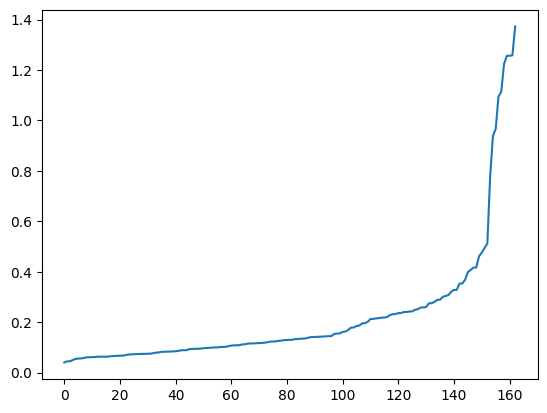

In [ ]:
# calculate k-distance graph
k_neighbor = 5
nbrs = NearestNeighbors(n_neighbors=k_neighbor).fit(emb_df)
distances, indices = nbrs.kneighbors(emb_df)
k_distance = distances[:,-1]/3

# sort the k-distances and plot the curve
k_distance.sort()
plt.plot(k_distance)

# identify the elbow point
knee = np.diff(k_distance, 2)
epsilon = knee.argmax() + 2  

# add 2 because of zero-based indexing
eps = k_distance[epsilon]

# Consider one decimal place
eps = int(eps*10)/10
print(f"Optimum eps: {eps}")

# 6. DBSCAN

Counter({0: 116, -1: 27, 2: 12, 1: 8})


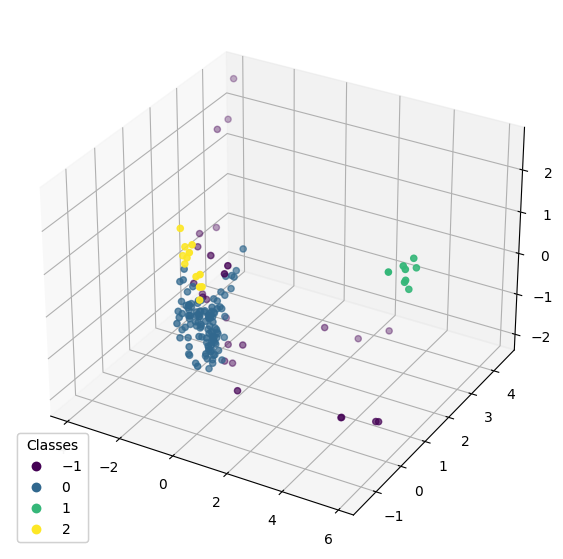

In [ ]:
np.random.seed(2)

#applying DBSCAN on dataset
from sklearn.cluster import DBSCAN
from collections import Counter

cluster = DBSCAN(min_samples=6,eps=eps).fit(get_pca(emb_df,3))
print(Counter(cluster.labels_))
get_3dplot(get_pca(emb_df,3),cluster.labels_)

# 7. Output

verifying scammers by backtracking the original graph

In [ ]:
res_scammers = []
res_non_scammers = []

#getting nodes from each clusters
for a in set(cluster.labels_):
    res = np.array(k.nodes())[cluster.labels_ == a]
    if len(res) <= 150:
        res_scammers.append(sorted(res))
    else:
        res_non_scammers.append(sorted(res))

print(f'  Size of Clusters\tNumber of Mismatches')
#backtracking to original graph
for nodes in res_scammers:
    res = []
    cnt = 0
    for a in nodes:
        res.extend(list(g2.neighbors(a)))
    res1 = sorted(set(res))
    for a in nodes:
        if a not in res1:
            cnt += 1
    print(f'\t{len(nodes)}\t\t\t{cnt}')

  Size of Clusters	Number of Mismatches
	116			0
	8			0
	12			0
	27			0
